In [0]:
# !pip install tokenizers
# !pip install eli5
# !pip install -U catalyst

In [9]:
# !pip install --upgrade wandb
# !wandb login <>

Successfully logged in to Weights & Biases!


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Olga/.netrc


In [10]:
import wandb
wandb.init(project="dpl")

import pandas as pd 
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook

import torch
from torch.utils.data import DataLoader
from torchtext  import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import Vectors

from tokenizers import SentencePieceBPETokenizer

from sklearn.base import BaseEstimator, ClassifierMixin
import eli5
from eli5.lime import TextExplainer


import nltk
from nltk import tokenize
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# TODO Заменить токенайзер на что-нибудь из tokenizers
# TODO catalyst
# TODO Чтобы модель сохранялась на лучшей эпохе (в каталисте уже есть такое)

# Data

In [11]:
def open_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        text_list = [line for line in f.readlines()]
    return text_list

In [12]:
# uncomment if google colab:
# import os 
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/')
# !wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
# !unzip 'wikitext-2-v1.zip'

fake = open_file("data/fake.txt")
real = open_file("data/real.txt")
df = pd.read_csv("data/dataset.csv")

In [13]:
print(len(fake), len(real), df.shape)
print(fake[:2])
print(real[:2])
df.head()

37366 37366 (74732, 2)
['Spinach has terrorized generations of veggie-phobic kids, and many grownups don\'t much like it, either.."I think it\'s a little bit of a shock to see that he\'s been able to do this,"\n', 'All day, every day, Cheryl Bernstein thanks her 16-month-old son. the boy is a little boy.\n']
["Spinach has terrorized generations of veggie-phobic kids, and many grownups don't much like it, either. But when it's combined with seasonings and feta cheese and wrapped in a golden crisp phyllo dough crust, even those who despise Popeye's Â\xadfavorite food ask for seconds.\n", 'All day, every day, Cheryl Bernstein thanks her 16-month-old son. "I gave life to Reid, but he gave me life - a reason to get clean and go on," she said yesterday after graduating from the Manhattan Family Treatment Court program.\n']


,text,label
0,"Is a skull from Petralona Cave, Greece, the ol...",real
1,The Network Readiness Index published by the W...,fake
2,Now they've got Justin Bieber too. He was just...,real
3,"NOGALES, Arizona — Jessica Elizabeth Orellana ...",real
4,Many companies that are using cloud computing ...,fake


In [14]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['wikitext-2/wiki.test.tokens', 'wikitext-2/wiki.train.tokens', 'wikitext-2/wiki.valid.tokens'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)

def tokenize(text, tokenizer=tokenizer):
    return tokenizer.encode(text).tokens

print(tokenize(fake[0]))
print(tokenize(real[0]))

['▁Spin', 'ach', '▁has', '▁terror', 'ized', '▁generations', '▁of', '▁ve', 'gg', 'ie', '-', 'ph', 'obic', '▁kids', ',', '▁and', '▁many', '▁grown', 'up', 's', '▁don', "'", 't', '▁much', '▁like', '▁it', ',', '▁either', '..', '"', 'I', '▁think', '▁it', "'", 's', '▁a', '▁little', '▁bit', '▁of', '▁a', '▁shock', '▁to', '▁see', '▁that', '▁he', "'", 's', '▁been', '▁able', '▁to', '▁do', '▁this', ',', '"', '▁']
['▁Spin', 'ach', '▁has', '▁terror', 'ized', '▁generations', '▁of', '▁ve', 'gg', 'ie', '-', 'ph', 'obic', '▁kids', ',', '▁and', '▁many', '▁grown', 'up', 's', '▁don', "'", 't', '▁much', '▁like', '▁it', ',', '▁either', '.', '▁But', '▁when', '▁it', "'", 's', '▁combined', '▁with', '▁season', 'ings', '▁and', '▁fet', 'a', '▁cheese', '▁and', '▁wrapped', '▁in', '▁a', '▁golden', '▁cr', 'isp', '▁p', 'hy', 'llo', '▁d', 'ough', '▁crust', ',', '▁even', '▁those', '▁who', '▁desp', 'ise', '▁Pope', 'y', 'e', "'", 's', '▁favorite', '▁food', '▁ask', '▁for', '▁seconds', '.', '▁']


In [15]:
MAX_VOCAB_SIZE = 50000
classes={'fake': 0, 'real': 1}


TEXT = data.Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, 
             pad_first=True, lower=True, eos_token='<eos>') 
LABEL = data.LabelField(dtype=torch.float, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = data.TabularDataset('data/dataset.csv', 
                                format='csv', fields=[('text', TEXT), ('label',LABEL),], 
                                skip_header=True)

TEXT.build_vocab(dataset,  max_size=MAX_VOCAB_SIZE, min_freq=2)
LABEL.build_vocab(dataset)
vocab = TEXT.vocab
print('Vocab size:', len(TEXT.vocab.itos))

train, test = dataset.split(0.8, stratified=True)
train, valid = train.split(0.8, stratified=True)

Vocab size: 20656


# Model

In [16]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2 *2, 1)
    def forward(self, x):
        
        x = self.embedding(x)
           
        _, (hidden, cell) = self.rnn(x)
        
        hidden = hidden.transpose(0,1)
        cell = cell.transpose(0,1)
        hidden = hidden.contiguous().view(hidden.size(0),-1)
        cell = cell.contiguous().view(cell.size(0),-1)
        x = torch.cat([hidden, cell], dim=1).squeeze(1)
        x = self.fc(x)
        return x

In [17]:
# class Batch:
#     "Object for holding a batch of data with mask during training."
#     def __init__(self, text, label):
#         self.text = text
#         self.label = label


# class BucketIteratorWrapper(DataLoader):
#     __initialized = False

#     def __init__(self, iterator: data.Iterator):
# #         super(BucketIteratorWrapper,self).__init__()
#         self.batch_size = iterator.batch_size
#         self.num_workers = 1
#         self.collate_fn = None
#         self.pin_memory = False
#         self.drop_last = False
#         self.timeout = 0
#         self.worker_init_fn = None
#         self.sampler = iterator
#         self.batch_sampler = iterator
#         self.__initialized = True

#     def __iter__(self):
#         return map(
#             lambda batch: {'features': Batch(batch.text, batch.label).text,
#                            'targets': Batch(batch.text, batch.label).label.unsqueeze(-1),
#                           },

#             self.batch_sampler.__iter__()
#         )

#     def __len__(self):
#         return len(self.batch_sampler)

In [18]:
batch_size = 256
num_epochs = 10

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )
model.to(device)
wandb.watch(model)
# wandb.init(project="dpl")

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    device=device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)

#train_iterator = BucketIteratorWrapper(train_iterator)
#valid_iterator = BucketIteratorWrapper(valid_iterator)
#test_iterator = BucketIteratorWrapper(test_iterator)

optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, cooldown=5)
criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

BCEWithLogitsLoss()

In [19]:
def accuracy_score(preds, y):
    preds = torch.round(torch.sigmoid(preds))
    preds = (preds == y).float()
    accuracy = preds.sum() / len(preds)
    return accuracy.item()

## TODO Catalyst

In [0]:
logdir = 'logdir3'
!rm -rf {logdir}

In [0]:
from catalyst.dl import SupervisedRunner, \
    CriterionCallback, AccuracyCallback

# input_keys - which key from dataloader we need to pass to the model
runner = SupervisedRunner(device=device)

runner.train(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders={'train': train_iterator, 'valid': valid_iterator},
    logdir="./logs/nlp",
    num_epochs=num_epochs,
    verbose=True,
    callbacks=[
        CriterionCallback(input_key="targets"),
        AccuracyCallback(input_key="targets")
        #EarlyStoppingCallback
    ]
)

In [0]:
a = next(iter(train_iterator))
print(a['targets'], a['features'])
a.keys(), a['targets'].size(), a['features'].size()

In [0]:
labels_real = 0
labels_fake = 0

for el in test_iterator:
    print('fake {}, real {}'.format(el['targets'].sum().item(), batch_size - el['targets'].sum().item()))
    #labels_fake += el['targets'].sum().item()
    #labels_real += batch_size - el['targets'].sum().item()
        
print(labels_real, labels_fake)

## Training process

In [20]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):
    model.train()

    running_loss = 0
    losses = []
    train_acc = []

    n_batches = len(iterator)
    
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    
    for i, batch in enumerate(iterator):
        x = batch.text
        y = batch.label
        optimizer.zero_grad()
        preds = model(x).squeeze(1)
        loss = criterion(preds, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
        curr_loss = loss.data.detach().item()
        losses.append(loss.item())

        acc = accuracy_score(preds, y)
        train_acc.append(acc)

        iterator.set_postfix(loss='%.5f' % curr_loss, acc='%.5f' % acc)

        wandb.log({
        "Train Accuracy": np.mean(train_acc),
        "Train Loss": curr_loss})

    return curr_loss, losses, train_acc

def _test_epoch(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    losses = []
    test_acc = []

    n_batches = len(iterator)

    with torch.no_grad():
        for batch in iterator:
            x = batch.text
            y = batch.label
            preds = model(x).squeeze(1)
            test_acc.append(accuracy_score(preds, y))

            loss = criterion(preds, y)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

    wandb.log({
        "Valid Accuracy": np.mean(test_acc),
        "Valid Loss": epoch_loss/n_batches})
    
    return epoch_loss / n_batches, losses, test_acc

def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=20, early_stopping=0):

    prev_loss = 10500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl, train_acc = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl, valid_acc = _test_epoch(model, valid_iterator, criterion)

        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)
        train_accs.extend(train_acc)
        valid_accs.extend(valid_acc)

        print('validation loss %.5f' % valid_loss, 'validation accuracy  %.5f' % np.mean(valid_accs))

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss, 'train_acc': np.mean(train_accs), 'valid_acc':np.mean(valid_accs)}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [15]:
history = nn_train(model, train_iterator, valid_iterator,
          criterion, optimizer, n_epochs=100, early_stopping=2)


validation loss 0.13240 validation accuracy  0.95346



validation loss 0.07237 validation accuracy  0.96356



validation loss 0.05896 validation accuracy  0.96842



validation loss 0.05745 validation accuracy  0.97109



validation loss 0.05863 validation accuracy  0.97275



validation loss 0.05521 validation accuracy  0.97420



validation loss 0.05890 validation accuracy  0.97530



validation loss 0.06773 validation accuracy  0.97617
Early stopping! best epoch: 5 val 0.05521


In [0]:
# torch.save(model.state_dict(), 'data/model_test')
# wandb.save('model.h5')

# Test and Eli5

In [22]:
# model.load_state_dict(torch.load('data/model_test', map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
def test_model(model, test_iterator):
    test_acc = []

    with torch.no_grad():
        for item in test_iterator:
            #x = item['features']
            #y = item['targets']
            x = item.text
            y = item.label
            preds = model(x).squeeze(1)
            test_acc.append(accuracy_score(preds, y))
    #print(type(test_acc), type(test_acc[0]))
    test_acc = np.mean(test_acc) 
    return np.mean(test_acc)

In [24]:
test_accuracy = test_model(model, test_iterator)
print('Test accuracy: {}'.format(np.mean(test_accuracy)))

Test accuracy: 0.9902012711864406


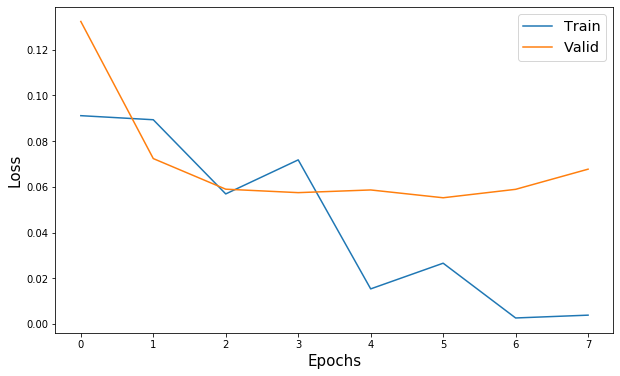

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

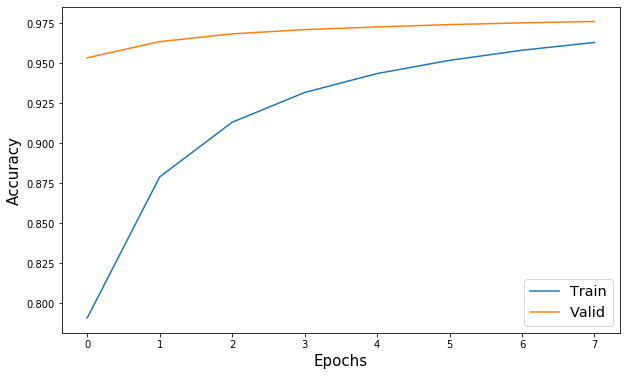

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_acc'])), history['train_acc'], label='Train')
plt.plot(np.arange(len(history['valid_acc'])), history['valid_acc'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

In [25]:
class LSTMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model, optimizer, scheduler, criterion):
        super(LSTMClassifier, self).__init__() 
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.classes_ = (0,1)

    def fit(self, X=None, y=None, **kwargs):
        #nn_train(self.model, train_iterator, valid_iterator, self.criterion, self.optimizer, n_epochs=5, early_stopping=2)
        return self

    def predict_proba(self, texts):
        """
        texts: list of texts
        :return: ndarray n_texts x n_classes
        """

        tokenized_texts = [tokenize(text) for text in texts]
    
        ids = [[vocab.stoi[token] for token in text] for text in tokenized_texts]
        
        for ind, el in enumerate(ids): # Чтобы до одинаковой длинны
            if len(el) < len(tokenized_texts[0]):
                while len(el) < len(tokenized_texts[0]):
                    el.append(1)
            if len(el) > len(tokenized_texts[0]):
                ids[ind] = el[:len(tokenized_texts[0])]            
        
        tensor = torch.tensor(ids)
        self.model.eval()
        with torch.no_grad():
            logits = self.model.forward(tensor)
        sigmoids = torch.sigmoid(logits)  # First predict the 'Real' prob
        opposite_class_prob = 1 - sigmoids  # Then calculate the 'Fake' prob
        probs = torch.cat((sigmoids, opposite_class_prob), dim=-1)
        
        return probs.detach().numpy()

    def predict(self, text):
        return int(torch.round(self.predict_proba(text)).item())

In [26]:
model_estimator = LSTMClassifier(model, optimizer, scheduler, criterion)
model_estimator.fit()

LSTMClassifier(criterion=BCEWithLogitsLoss(),
               model=MyModel(
  (embedding): Embedding(20656, 100)
  (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
),
               optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
),
               scheduler=<torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x000002A20548E748>)

In [27]:
from IPython.display import display, HTML

for i in range(0, 50, 10):
    text_fake = fake[i]
    text_real = real[i]
    te = TextExplainer(random_state=42)
    
    te.fit(doc=text_fake, predict_proba=model_estimator.predict_proba)
    print('True label: Fake')
    display(te.show_prediction(target_names=['Real','Fake']))
    
    te.fit(doc=text_real, predict_proba=model_estimator.predict_proba)
    print('True label: Real')
    display(te.show_prediction(target_names=['Real','Fake']))
    
    

True label: Fake


True label: Real


True label: Fake


True label: Real


True label: Fake


True label: Real


True label: Fake


True label: Real


True label: Fake


True label: Real


In [28]:
text = fake[23]
text
print(model_estimator.predict_proba([text]))
te = TextExplainer(random_state=42)
te.fit(doc=text, predict_proba=model_estimator.predict_proba)
te.show_prediction(target_names=['Real','Fake'])

[[0.0077327 0.9922673]]
